In [ ]:
# Constants
MAX_NO_ROWS = 1000000
LOAD_MODEL=True
SKIP_TRAINING=True
FEATURE = 'ft_washing_machine'
SEQ_PER_BATCH = 1024
SEQ_LEN = 32
N_STRIDES = 1
NORM_TYPE = 'max'
LEARNING_RATE = 1e-3
CLIP_VALUE = 10.
EPOCHS = 7
CHECKPOINT_PATH = f"lstm_training_{FEATURE}/cp.ckpt"

In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
print(tf.version.VERSION)

2.11.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Dissertation

/content/drive/My Drive/Colab Notebooks/Dissertation


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lib.chunk_reader import read_labels, get_merged_chunks, get_dates
from lib.plotting import plot_ft_days, plot_model_history, plot_prediction_windows
from lib.analysis import print_heads_tails

In [ ]:
labels = read_labels(1)
for house in range(1,2):
    print('House {}: '.format(house), labels[house], '\n')

House 1:  ['mains_active', 'mains_apparent', 'mains_rms', 'aggregate_apparent', 'ft_boiler', 'ft_solar_thermal_pump', 'ft_washing_machine', 'ft_dishwasher', 'ft_tv', 'ft_kitchen_lights', 'ft_htpc', 'ft_kettle', 'ft_toaster', 'ft_fridge', 'ft_microwave', 'ft_amp_livingroom', 'ft_adsl_router', 'ft_livingroom_s_lamp', 'ft_lighting_circuit', 'ft_subwoofer_livingroom', 'ft_livingroom_lamp_tv', 'ft_kitchen_phone&stereo', 'ft_coffee_machine', 'ft_gas_oven', 'ft_data_logger_pc', 'ft_office_lamp2', 'aggregate_active', 'unix_time'] 



In [ ]:
ref_chunk_df = get_merged_chunks(1, 1)
print('Original DF shape', ref_chunk_df.shape)
print('---')
ref_chunk_df = ref_chunk_df[0:MAX_NO_ROWS]

reading house 1; chunk 1
reading file data/ukdale-parsed-chunks/house_1/chunk_1.dat; for house 1 and chunk 1
read house 1; chunk 1; df.shape is (4500000, 29)
Original DF shape (4500000, 29)
---


In [ ]:
dates = {}
# for house in range(1,2):
dates[1] = get_dates(ref_chunk_df, 1)

House 1 data contain 71 days from 2013-04-11 to 2013-06-20.
['2013-04-11', '2013-04-12', '2013-04-13', '2013-04-14', '2013-04-15', '2013-04-16', '2013-04-17', '2013-04-18', '2013-04-19', '2013-04-20', '2013-04-21', '2013-04-22', '2013-04-23', '2013-04-24', '2013-04-25', '2013-04-26', '2013-04-27', '2013-04-28', '2013-04-29', '2013-04-30', '2013-05-01', '2013-05-02', '2013-05-03', '2013-05-04', '2013-05-05', '2013-05-06', '2013-05-07', '2013-05-08', '2013-05-09', '2013-05-10', '2013-05-11', '2013-05-12', '2013-05-13', '2013-05-14', '2013-05-15', '2013-05-16', '2013-05-17', '2013-05-18', '2013-05-19', '2013-05-20', '2013-05-21', '2013-05-22', '2013-05-23', '2013-05-24', '2013-05-25', '2013-05-26', '2013-05-27', '2013-05-28', '2013-05-29', '2013-05-30', '2013-05-31', '2013-06-01', '2013-06-02', '2013-06-03', '2013-06-04', '2013-06-05', '2013-06-06', '2013-06-07', '2013-06-08', '2013-06-09', '2013-06-10', '2013-06-11', '2013-06-12', '2013-06-13', '2013-06-14', '2013-06-15', '2013-06-16', '

In [ ]:
# Constants 2
rows_per_day = ref_chunk_df.loc[:dates[1][2]].shape[0]

(31700,)
(15850, 2)


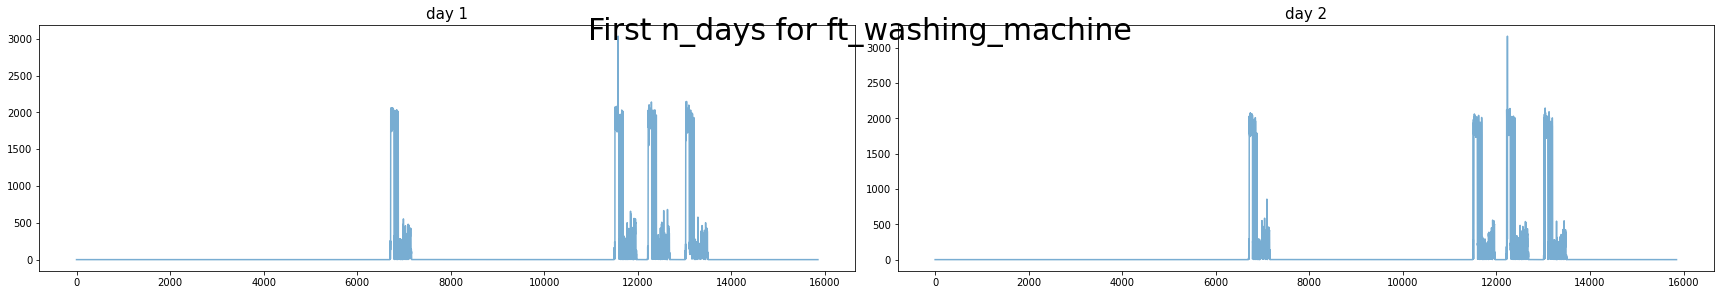

In [ ]:
plot_ft_days(ref_chunk_df, dates, 1, FEATURE, 2)

In [ ]:
from algos.processing import split_df_by_dates
from algos.lstm import create_model, train, predict
from algos.norm import get_ref_norm

In [ ]:
# Separate house 1 data into train, validation and test data
df_train, df_val, df_test  =  split_df_by_dates(ref_chunk_df, dates=dates, house=1)

df_train.shape:  (521300, 29)
df_val.shape:  (316800, 29)
df_test.shape:  (190700, 29)


In [ ]:
ref_norm = get_ref_norm(df_train, NORM_TYPE)

ref_mean: 325.09124755859375; ref_max: 6002.919921875; ref_std: 434.2580871582031
norm_type: max; ref_norm 6002.919921875


In [ ]:
model = create_model(seq_len=SEQ_LEN, learning_rate=LEARNING_RATE, clipvalue=CLIP_VALUE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32, 16)            80        
                                                                 
 bidirectional (Bidirectiona  (None, 32, 256)          148480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,264,977
Trainable params: 1,264,977
Non-

In [ ]:
# !!!!!!!Counter!!!!!!! 
# Manually update for every new loaded training
# Run Counter = 43 + 7

# Load and or Train
if LOAD_MODEL:
  model.load_weights(CHECKPOINT_PATH)
if SKIP_TRAINING:
  pass
else:
  model, history, time_spent = train(model, feature=FEATURE, df_train=df_train, df_val=df_val, ref_norm=ref_norm, seq_len=SEQ_LEN, seq_per_batch=SEQ_PER_BATCH, epochs=EPOCHS, checkpoint_path=CHECKPOINT_PATH)

In [ ]:
if not SKIP_TRAINING:
    print('Time spent', time_spent)
    plot_model_history(history)

In [ ]:
# Predict from test split
y_test, y_pred = predict(model, feature=FEATURE, df_test=df_test, ref_norm=ref_norm, seq_len=SEQ_LEN, seq_per_batch=SEQ_PER_BATCH)

x_test.shape, y_test.shape
(190700, 1) (190700, 1)
self.data_len 190700
stride 1
seq_per_batch 1024
seq_len 32
n_batches 187
x.shape, y.shape (191488, 32, 1) (191488,)
batch_index 0
187/187 [==============================] - 15s 32ms/step
y_test.shape, y_pred.shape
(191488,) (191488, 1)
y_test.shape, y_pred.shape
(191488,) (191488,)
Normalized: y_test.mean, y_pred.mean
0.0026099759 0.0028559724
Denormalized: y_test.mean, y_pred.mean
15.667476 17.364267


In [ ]:
# plot_prediction_windows(FEATURE, y_test_denorm, y_pred_denorm)

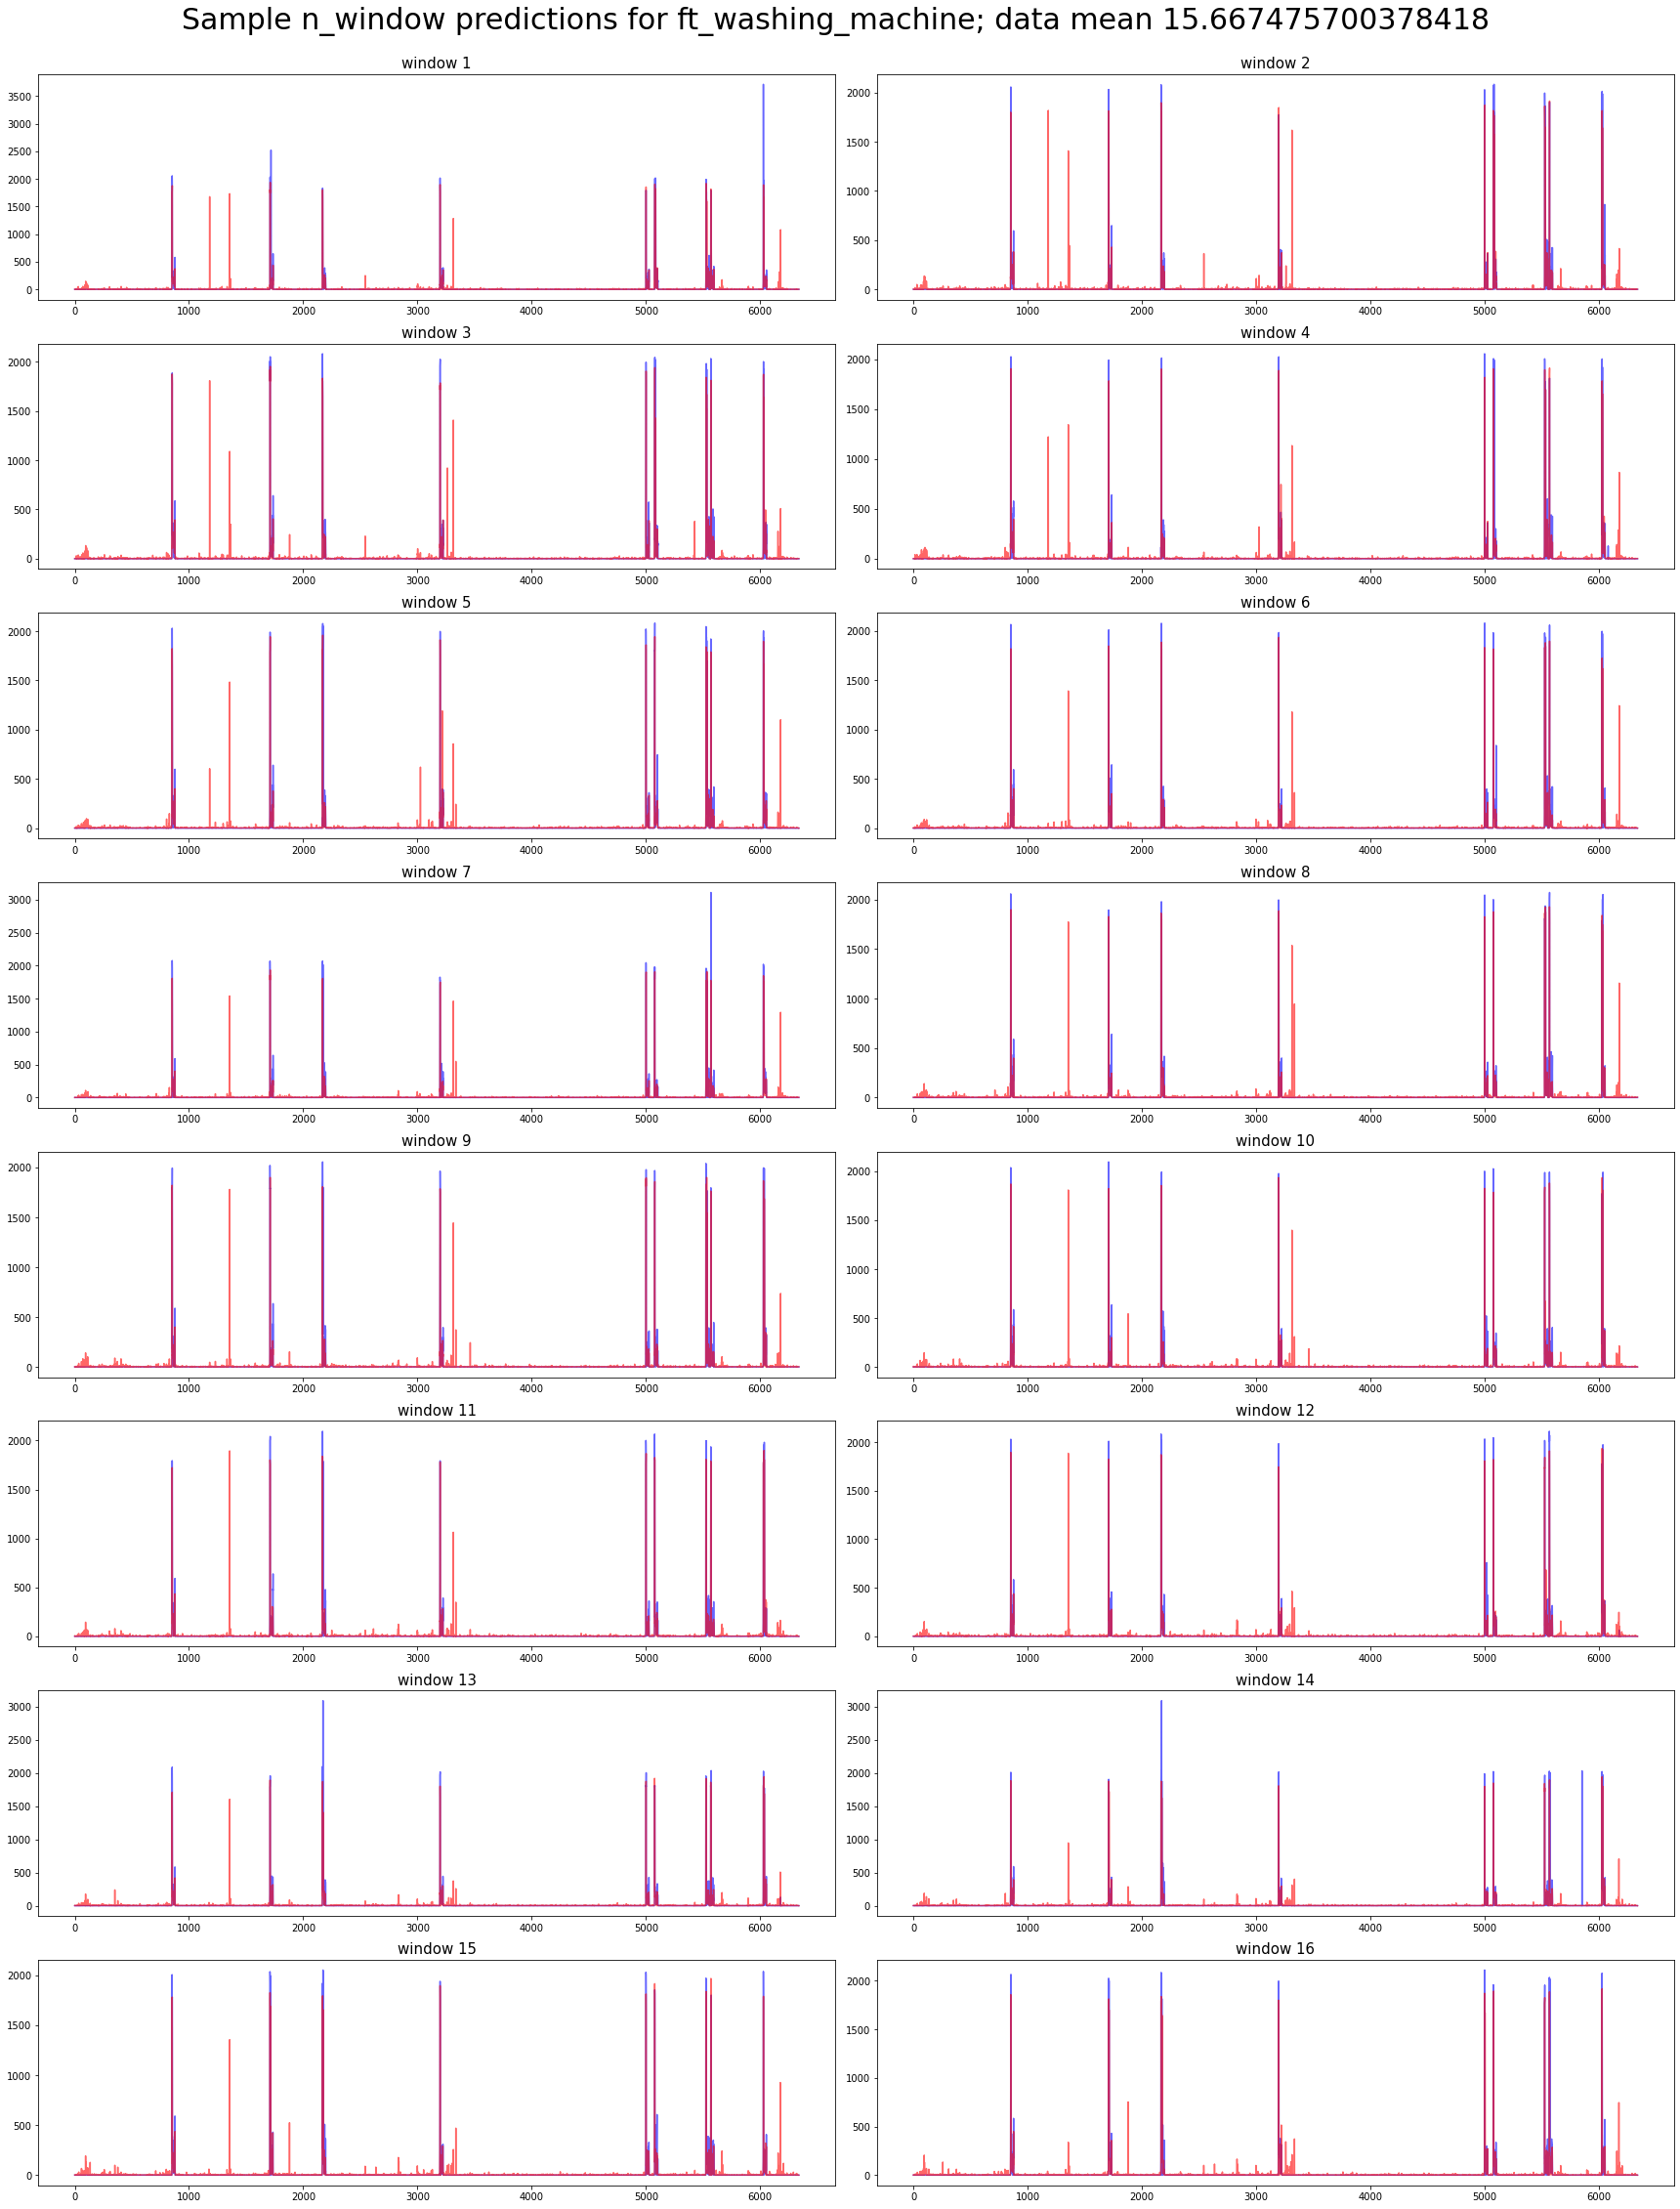

In [ ]:
n_samples = int(rows_per_day * 0.2)
plot_prediction_windows(FEATURE, y_test, y_pred, use_active=False, n_samples=n_samples)

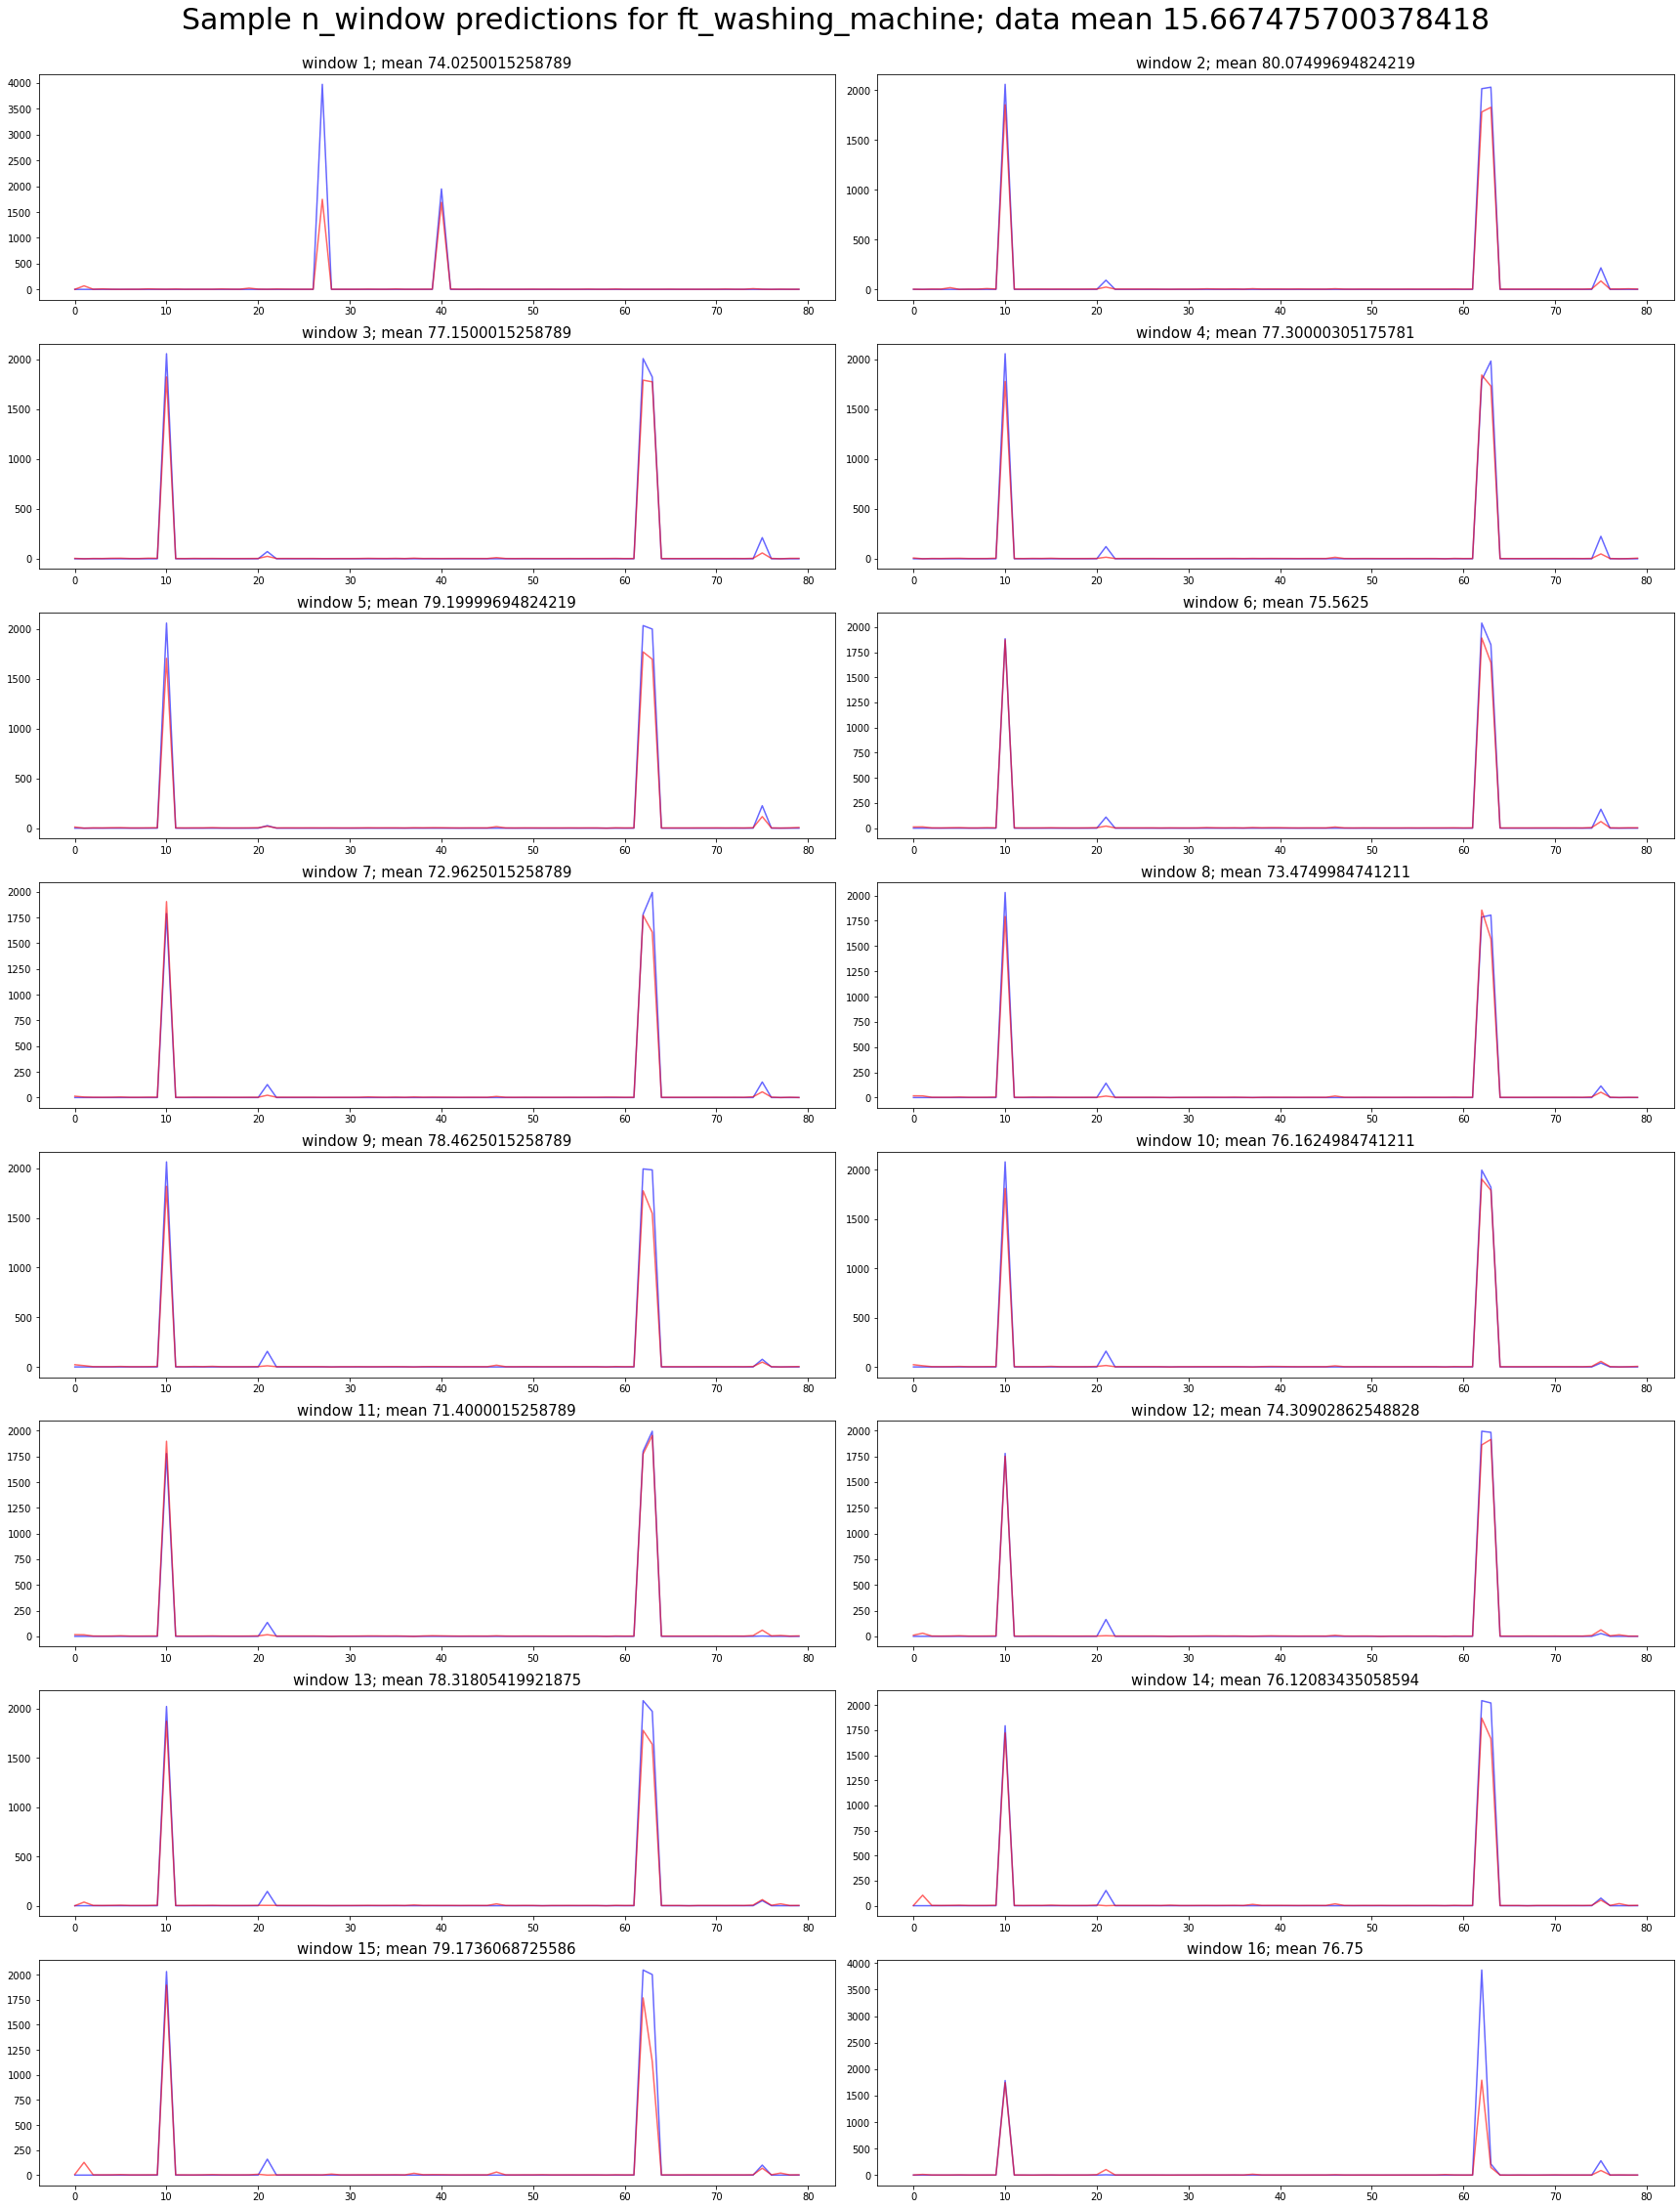

In [ ]:
n_samples = 80
plot_prediction_windows(FEATURE, y_test, y_pred, use_active=True, active_factor=4, n_samples=n_samples)

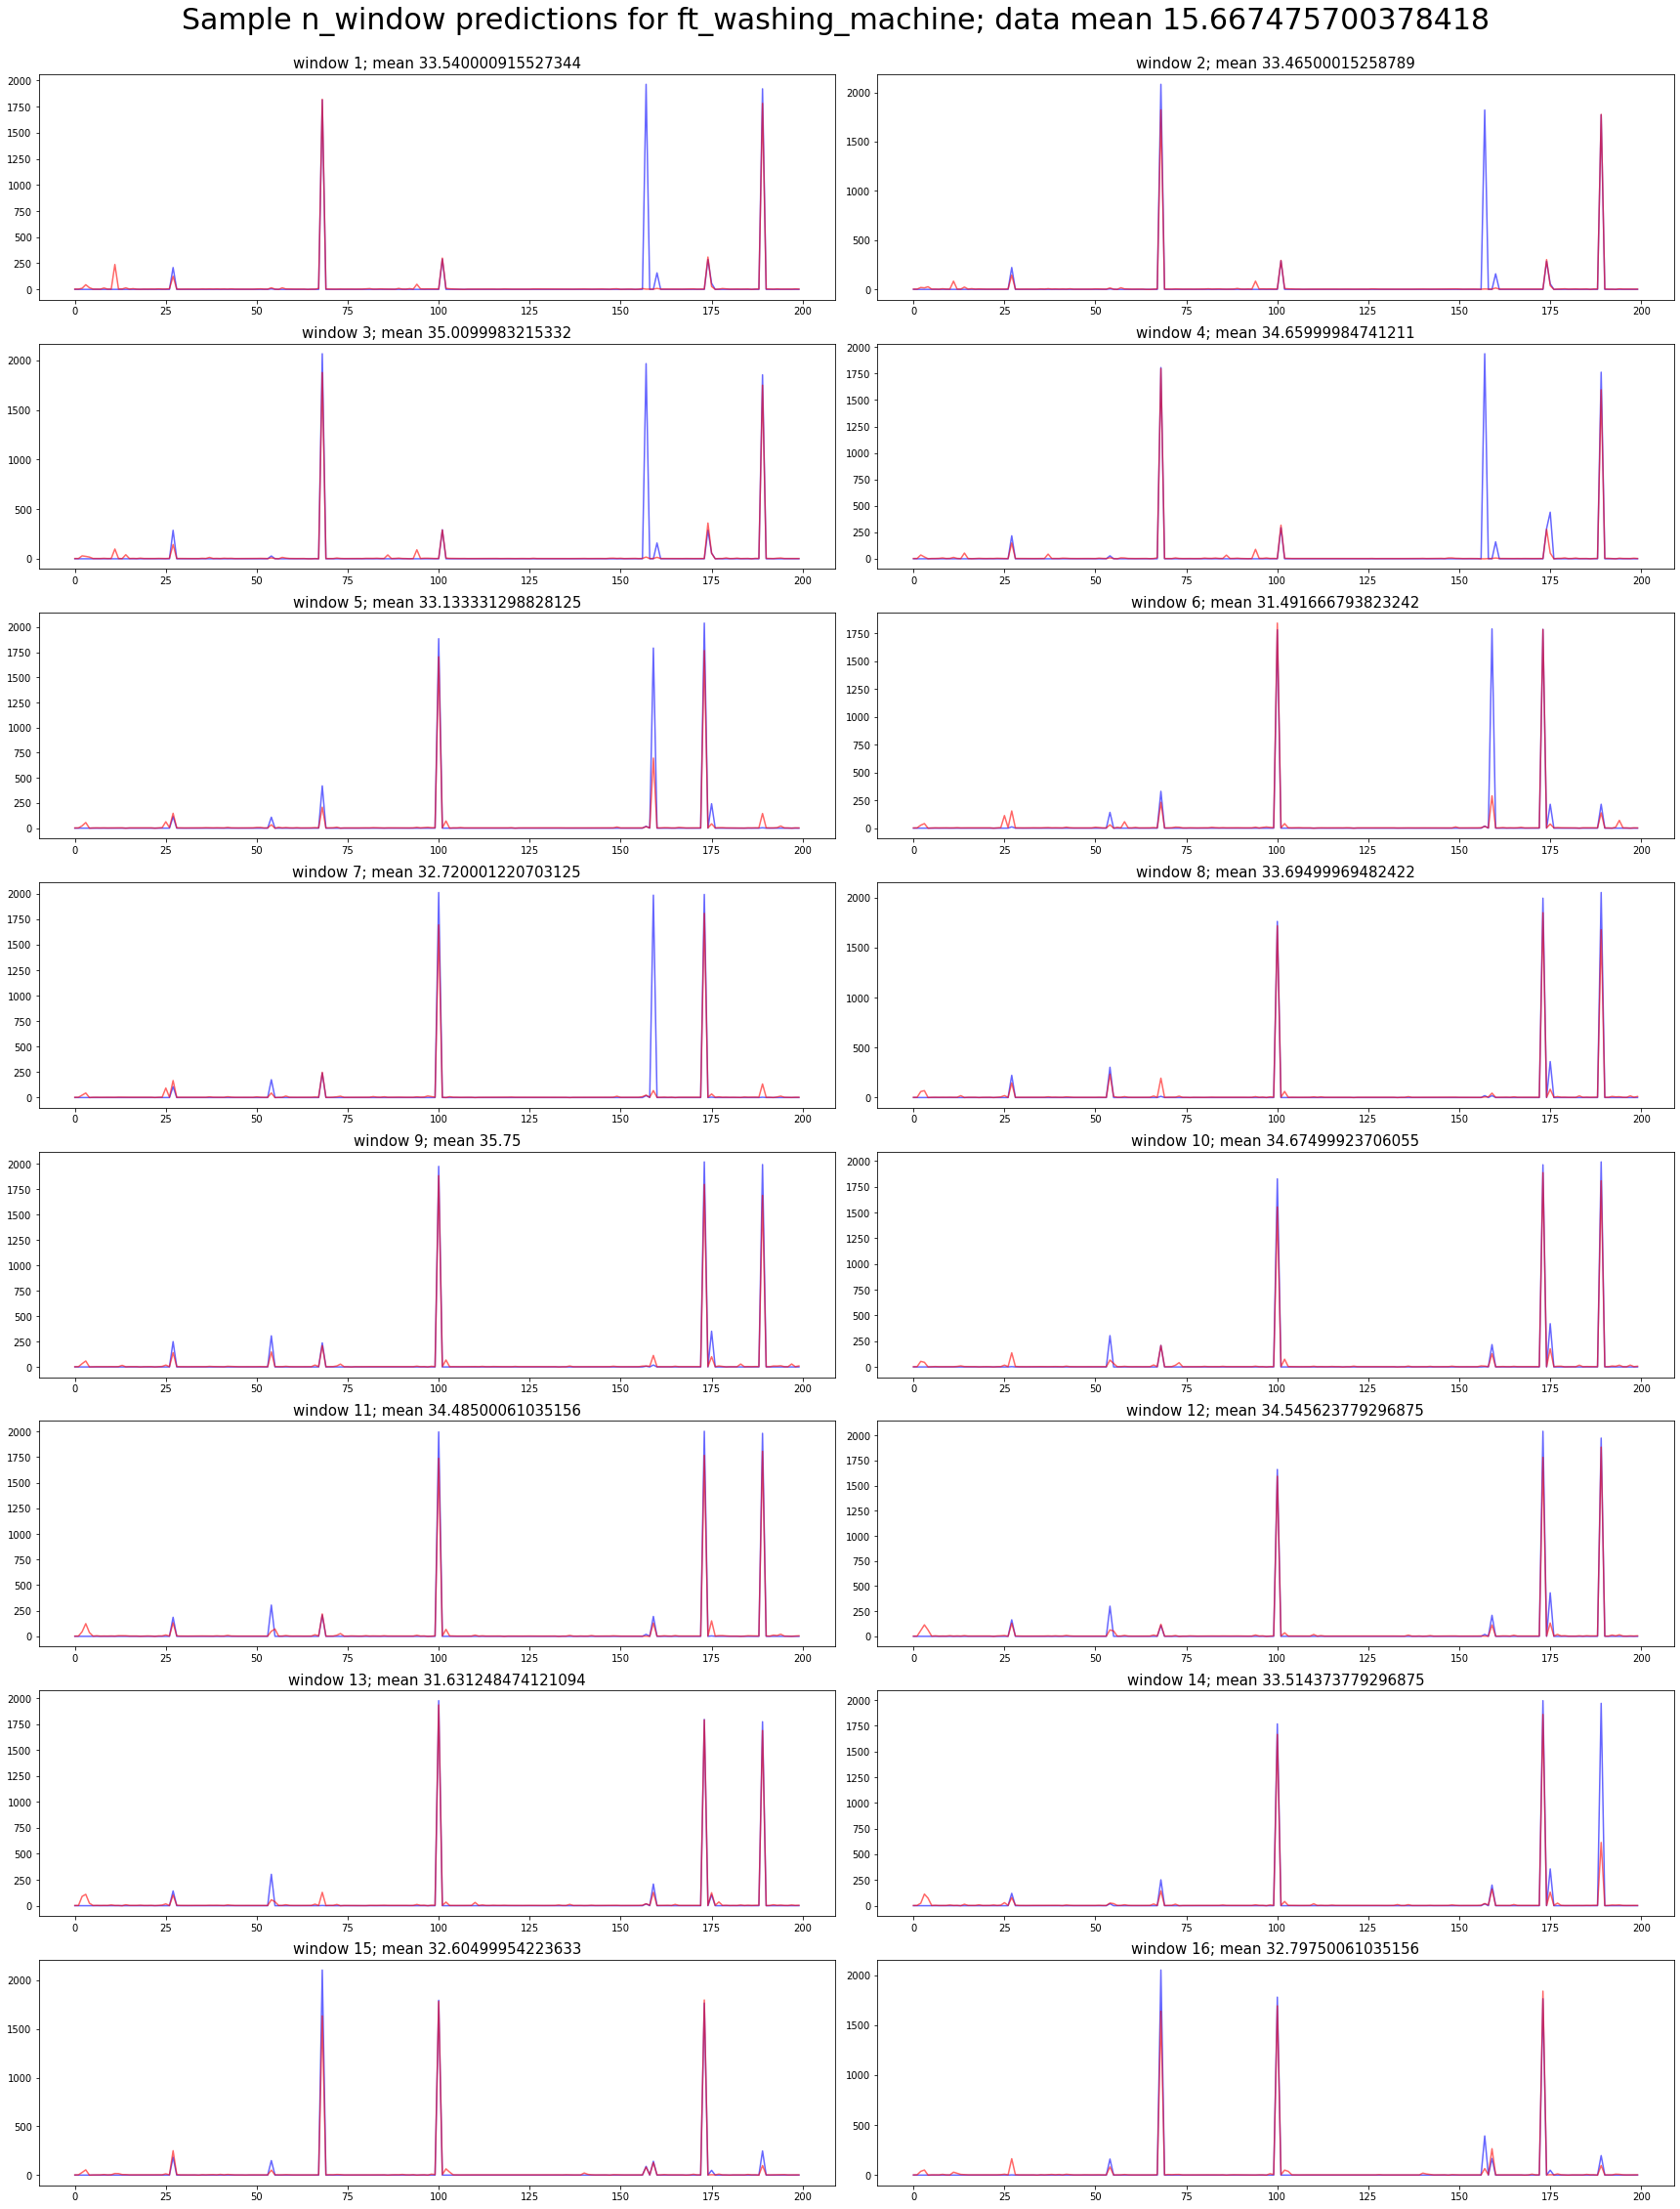

In [ ]:
n_samples = 200
plot_prediction_windows(FEATURE, y_test, y_pred, use_active=True, n_samples=n_samples)

In [ ]:
from lib import analysis
from lib.logging import losses_to_file, metrics_to_file

In [ ]:
params = {}
params["algo"] = 'lstm'
params["feature"] = FEATURE
params["seq_len"] = SEQ_LEN
params["seq_per_batch"] = SEQ_PER_BATCH
params["strides"] = N_STRIDES
params["epochs"] = EPOCHS
params["train_rows"] = df_train.shape[0]
params["val_rows"] = df_val.shape[0]
params["test_rows"] = df_test.shape[0]
params["norm_value"] = ref_norm
params["norm_type"] = NORM_TYPE
params["learning_rate"] = LEARNING_RATE
params["loss"] = 'adam'
params["clipvalue"] = CLIP_VALUE

In [ ]:
print(params)

{'algo': 'lstm', 'feature': 'ft_washing_machine', 'seq_len': 32, 'seq_per_batch': 1024, 'strides': 1, 'epochs': 7, 'train_rows': 521300, 'val_rows': 316800, 'test_rows': 190700, 'norm_value': 6002.92, 'norm_type': 'max', 'learning_rate': 0.001, 'loss': 'adam', 'clipvalue': 10.0}


In [ ]:
results = analysis.classification_results(y_test, y_pred, on_threshold = 50)

metrics = {}
metrics["mae"] = analysis.mse_loss(y_test, y_pred)
metrics["mse"] = analysis.mae_loss(y_test, y_pred)
metrics["f1"] = analysis.f1(results)
metrics["accuracy"] = analysis.accuracy(results)
metrics["precision"] = analysis.precision(results)
metrics["recall"] = analysis.recall(results)

In [ ]:
print(metrics)

{'mae': 3407.1044887433122, 'mse': 10.073495120092508, 'f1': 0.724044538068011, 'accuracy': 0.9808447526737968, 'precision': 0.6689837341860142, 'recall': 0.7889818002951303}


In [ ]:
if not SKIP_TRAINING:
    losses_to_file(1, params, history.history)

In [ ]:
metrics_to_file(1, params, metrics)